how to implement the movie review sentiment with RNNs step by step practically. We will start with a detailed explanation of analyzing and preprocessing the movie review data and developing a simple LSTM network. We then move on to boosting the performance with multiple LSTM layers. After that, we plot the learning curves to visualize the progress of the model learning.

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras import layers, models, losses, optimizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

In [ ]:
# keras bult in IMDb dataset
# set vocab size and keep only this many frequent words
vocab_size = 5000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocab_size)

In [ ]:
# print out training and testing data that was loaded
# 25000 training samples
# 12500 positive samples
# 25000 test samples
print('Number of training samples: ', len(y_train))
print('Number of positive samples:', sum(y_train))
print('Number of test samples:', len(y_test))

Number of training samples:  25000
Number of positive samples: 12500
Number of test samples: 25000


In [ ]:
# print training sample
# each word represented by an integer
# integer value indicates frequency of the word
print(X_train[0])
# use word dictionary to map integer to word
word_index = imdb.get_word_index()
index_word = {index: word for word, index in word_index.items()}
print([index_word.get(i, ' ') for i in X_train[0]])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 2, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 2, 19, 178, 32]
['the', 'as', 'you', 'with', 'out', 'themselves', 'powerful', 'lets', 'love

In [ ]:
# analyze length of each sample
# all input sequences to RNN must be of same length
review_lengths = [len(x) for x in X_train]
# plot distribution of document lengths
review_lengths

[218,
 189,
 141,
 550,
 147,
 43,
 123,
 562,
 233,
 130,
 450,
 99,
 117,
 238,
 109,
 129,
 163,
 752,
 212,
 177,
 129,
 140,
 256,
 888,
 93,
 142,
 220,
 193,
 171,
 221,
 174,
 647,
 233,
 162,
 597,
 234,
 51,
 336,
 139,
 231,
 704,
 142,
 861,
 132,
 122,
 570,
 55,
 214,
 103,
 186,
 113,
 169,
 469,
 138,
 302,
 766,
 351,
 146,
 59,
 206,
 107,
 152,
 186,
 431,
 147,
 684,
 383,
 324,
 252,
 263,
 787,
 211,
 314,
 118,
 390,
 132,
 710,
 306,
 167,
 115,
 95,
 158,
 156,
 82,
 502,
 314,
 190,
 174,
 60,
 145,
 214,
 659,
 408,
 515,
 461,
 202,
 238,
 170,
 107,
 171,
 158,
 145,
 790,
 258,
 287,
 67,
 123,
 975,
 775,
 236,
 195,
 274,
 214,
 91,
 1038,
 815,
 183,
 206,
 50,
 118,
 147,
 141,
 60,
 56,
 439,
 439,
 213,
 144,
 533,
 303,
 203,
 563,
 129,
 153,
 55,
 92,
 174,
 187,
 183,
 165,
 78,
 198,
 156,
 223,
 127,
 61,
 362,
 84,
 57,
 176,
 159,
 57,
 159,
 165,
 213,
 194,
 149,
 130,
 203,
 19,
 98,
 466,
 525,
 130,
 322,
 153,
 408,
 215,
 472,
 143,
 1

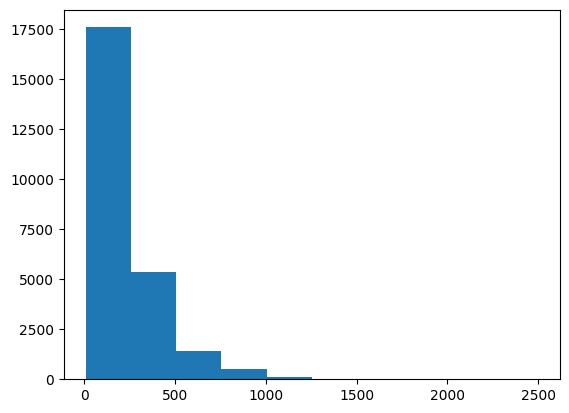

In [ ]:
# noted out to prevent double plots
plt.hist(review_lengths, bins=10)
plt.show()

In [ ]:
# majority of reviews around 200 words long
# set 200 as universal sequence length
# pad shorter reviews with zeros and cutting longer reviews
# use pad_sequences from keras
maxlen = 200
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)
# print out input sequences
print('X_train shape after padding:', X_train.shape)
print('X_test shape after padding:', X_test.shape)

X_train shape after padding: (25000, 200)
X_test shape after padding: (25000, 200)


In [ ]:
# building LSTM netwrok
# training and testing datasets ready, RNN can be built
# fix random seed and initiate keras sequential model
tf.random.set_seed(42)
model = models.Sequential()

In [ ]:
# input sequences are encoded vectors
# need to be changed to dense vectors using embedding layer from keras
# input sequences made of vocab_size=5000 unique word tokens into
# dense vectors of size 32
embedding_size = 32
model.add(layers.Embedding(vocab_size, embedding_size))


In [ ]:
# recurrent LSTM layer
# single layer with 50 nodes
# output layer with sigmoid activation function
# because binary classification
model.add(layers.LSTM(50))
model.add(layers.Dense(1, activation='sigmoid'))
# display model summary to double check layers
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 32)          160000    
                                                                 
 lstm_3 (LSTM)               (None, 50)                16600     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 176,651
Trainable params: 176,651
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# compile model with Adam optimizer
# use binary cross-entropy as optimaztion target
model.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['accuracy'])

In [ ]:
# train model with batches of 64 size for three epochs
batch_size = 64
n_epoch = 3
model.fit(X_train, y_train, batch_size=batch_size,
          epochs=n_epoch, validation_data=(X_test, y_test))

Epoch 1/3
391/391 [==============================] - 41s 96ms/step - loss: 0.4178 - accuracy: 0.7990 - val_loss: 0.3205 - val_accuracy: 0.8671
Epoch 2/3
391/391 [==============================] - 12s 30ms/step - loss: 0.2663 - accuracy: 0.8918 - val_loss: 0.3126 - val_accuracy: 0.8709
Epoch 3/3
391/391 [==============================] - 8s 21ms/step - loss: 0.2287 - accuracy: 0.9109 - val_loss: 0.3108 - val_accuracy: 0.8684


In [ ]:
# evaluate classification accuracy on testing set
acc = model.evaluate(X_test, y_test, verbose=0)[1]
print('Test accuracy:', acc)

Test accuracy: 0.8683599829673767


In [ ]:
# boost perfromance with multiple LSTM layers
# stack two recurrent layers
# new model and add embedding layer, two LSTM layers and output layer
model = models.Sequential()
model.add(layers.Embedding(vocab_size, embedding_size))
# first layer returns sequences to feed output into second layer
# 20% dropout to both LSTM layers to reduce overfitting
# due to more parameters to train
model.add(layers.LSTM(50, return_sequences=True, dropout=0.2))
model.add(layers.LSTM(50, dropout=0.2))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
# print model summary
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 32)          160000    
                                                                 
 lstm_4 (LSTM)               (None, None, 50)          16600     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 196,851
Trainable params: 196,851
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# Adam optimizer
optimizer = optimizers.Adam(lr=0.003)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])


In [ ]:
# train stacked model for 7 epochs
n_epoch = 7
model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epoch,
          validation_data=(X_test, y_test))

Epoch 1/7
391/391 [==============================] - 42s 98ms/step - loss: 0.4179 - accuracy: 0.7974 - val_loss: 0.3323 - val_accuracy: 0.8582
Epoch 2/7
391/391 [==============================] - 15s 37ms/step - loss: 0.2677 - accuracy: 0.8932 - val_loss: 0.3183 - val_accuracy: 0.8675
Epoch 3/7
391/391 [==============================] - 12s 30ms/step - loss: 0.2336 - accuracy: 0.9092 - val_loss: 0.3191 - val_accuracy: 0.8678
Epoch 4/7
391/391 [==============================] - 11s 29ms/step - loss: 0.2095 - accuracy: 0.9178 - val_loss: 0.3087 - val_accuracy: 0.8722
Epoch 5/7
391/391 [==============================] - 10s 27ms/step - loss: 0.1812 - accuracy: 0.9318 - val_loss: 0.3456 - val_accuracy: 0.8665
Epoch 6/7
391/391 [==============================] - 13s 34ms/step - loss: 0.1608 - accuracy: 0.9389 - val_loss: 0.3859 - val_accuracy: 0.8570
Epoch 7/7
391/391 [==============================] - 12s 31ms/step - loss: 0.1401 - accuracy: 0.9480 - val_loss: 0.4290 - val_accuracy: 0.8565

In [ ]:
# verify test accuracy
acc = model.evaluate(X_test, y_test, verbose=0)[1]
print('Test accuracy with stacked LSTM:', acc)

Test accuracy with stacked LSTM: 0.8565199971199036


In [ ]:
##Plotting the Leaning Curve
##Learning curve shows performance of the model useful for diagnosing underfitting and overfitting
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [ ]:
from sklearn.linear_model import LogisticRegression

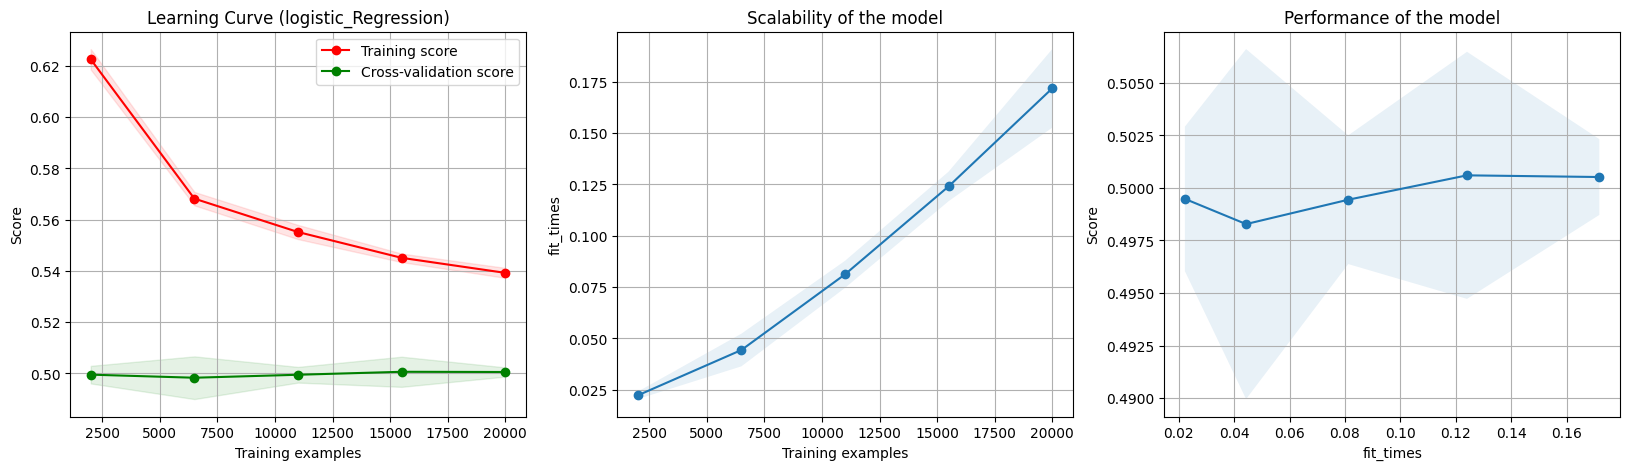

In [ ]:
estimator = GaussianNB(var_smoothing=1e-09)
# call plot_learning_curve
estimator = LogisticRegression()
title = "Learning Curve (logistic_Regression)"
X=X_train
y=y_train
cv = 5
n_jobs = -1
axes=None
ylim=(0,1)
train_sizes=np.linspace(0.1, 1.0, 5)
plot_learning_curve(estimator, title, X, y, axes=axes, cv=cv, n_jobs=n_jobs,train_sizes=train_sizes)
plt.show()